On this notebook , we will attempt a preprocessing step before using the RoBERTa model since it has a max input length of 512 and our reviews are much longer. The longest sequence we have is around 1500 so we will break each review into 3 parts which we will be able to trace back to the original review using IDs and then aggregate.

In [1]:
!pip install datasets
from IPython.display import clear_output
clear_output()

In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
import os
import torch
import numpy as np
from google.colab import drive
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
# Loading the dataset from drive
df = pd.read_csv("/content/drive/My Drive/DSC 514 NLP/sampled_data.csv")
df.head()

,movie_id,plot_summary,duration,genre,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,rating_y,review_summary,whole_review
0,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,1 February 2006,ur5945598,True,Oh where can I start on why alleged comedians ...,10,Chaplin strikes comic gold!,Oh where can I start on why alleged comedians ...
1,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,11 August 2005,ur5805910,True,"We follow ""the little fellow"" (Chaplin), in hi...",10,Chaplin's delightful bonhomie & innocence,"We follow ""the little fellow"" (Chaplin), in hi..."
2,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,22 June 2000,ur0773000,False,I recently saw this movie with a live orchestr...,9,"As fresh, funny, and moving as the day it was ...",I recently saw this movie with a live orchestr...
3,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,9 March 2009,ur0361658,False,The Gold Rush (1925) was a big undertaking for...,10,The Cinema of Charles Chaplin: The Gold Rush,The Gold Rush (1925) was a big undertaking for...
4,tt0017136,"Sometime in the future, the city of Metropolis...",2h 33min,"['Drama', 'Sci-Fi']",8.3,1927-03-13,"The film is set in the year 2026, in the extra...",7 March 2015,ur13977076,True,This sci-fi classic is set in a future where t...,10,A science fiction classic,This sci-fi classic is set in a future where t...


We will assign a unique ID to each review (review_id) before splitting the review:

In [5]:
# Unique review ID to each row
df['review_id'] = df.index

In [ ]:
# Creating a HuggingFace dataset
dataset = Dataset.from_pandas(df[['review_text', 'is_spoiler', 'review_id']])

In [7]:
# Loading the tokenizer for roberta from pretrained
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
# Next, this function will split the review into parts of 512 tokens each which is the maximum input for roberta
# and will also keep the review_id and the label for each chunk created

def chunk_review(batch):
    chunk_size = 512
    all_chunks = []  # a list to store all results

    # Looping through each row in the batch
    for review_text, is_spoiler, review_id in zip(batch["review_text"], batch["is_spoiler"], batch["review_id"]):
        tokens = tokenizer(review_text, truncation=False) # tokenizing, without truncating
        input_ids = tokens["input_ids"]                   # getting the id for the tokens
        attention_mask = tokens["attention_mask"]         # getting the attention mask

        # Now, we split the review to chunks of size 512 max
        for i in range(0, len(input_ids), chunk_size):
            all_chunks.append({
                "review_id": review_id,
                "input_ids": input_ids[i:i+chunk_size],
                "attention_mask": attention_mask[i:i+chunk_size], # we use the same label for all chunks of the same review
                "label": is_spoiler })

    # Returning a dictionary of lists to fit the format of hugging face
    return {
        "review_id": [chunk["review_id"] for chunk in all_chunks],
        "input_ids": [chunk["input_ids"] for chunk in all_chunks],
        "attention_mask": [chunk["attention_mask"] for chunk in all_chunks],
        "label": [chunk["label"] for chunk in all_chunks]}


In [9]:
# So now we can apply the chunking
# changed batched to True since now we are returning a list
dataset_chunked = dataset.map(chunk_review, batched=True, remove_columns=["review_text", "is_spoiler"])
dataset_chunked = dataset_chunked.flatten_indices()

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


Flattening the indices:   0%|          | 0/6590 [00:00<?, ? examples/s]

In [10]:
print(dataset_chunked)

Dataset({
    features: ['review_id', 'input_ids', 'attention_mask', 'label'],
    num_rows: 6590
})


In [11]:
# Splitting after apllying the chunking using the train-test split from Dataset , we want to keep the review_id
dataset_split = dataset_chunked.train_test_split(test_size=0.2, seed=42)

In [12]:
# Formatting for Pytorch in order to convert these columns and be ready to used from Hugging Face
dataset_split.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [13]:
print(dataset_chunked[0]) # this should not return nested lists

{'review_id': 0, 'input_ids': [0, 7516, 147, 64, 38, 386, 15, 596, 1697, 28972, 197, 1183, 42, 822, 13, 7125, 116, 30800, 6, 24, 18, 95, 6269, 4, 45527, 6, 18606, 28291, 18, 2664, 3914, 2048, 16, 10, 4613, 410, 22650, 6, 61, 2386, 123, 7, 109, 5, 144, 10861, 17605, 19650, 821, 8299, 4, 497, 5, 276, 86, 6, 37, 18, 10, 8840, 2598, 6, 3030, 7, 146, 402, 9, 1003, 4, 9136, 6, 37, 7416, 9, 33884, 8, 5, 372, 1151, 77, 37, 5315, 1637, 6, 53, 15, 39, 9794, 7, 465, 5, 1637, 4691, 293, 6, 37, 6952, 13, 215, 3280, 383, 25, 20310, 6, 689, 36, 3983, 7022, 39, 9759, 8, 4441, 24, 13, 3630, 16, 10, 4187, 1310, 43, 8, 657, 36, 700, 14528, 5712, 13, 390, 54, 32, 95, 7209, 198, 123, 7, 146, 1531, 9, 123, 6, 8, 47, 64, 75, 244, 619, 13, 5, 2173, 43, 178, 6, 9, 768, 6, 358, 1310, 6, 358, 30146, 16, 888, 233, 9, 5, 527, 6, 98, 24, 18, 45, 95, 10, 651, 9, 7031, 1545, 12, 31586, 11248, 4, 85, 18, 67, 966, 19280, 14, 37, 18, 215, 10, 9256, 12576, 6, 37, 18, 2882, 7, 458, 5, 2441, 19, 39, 1029, 12, 16823, 8, 64,

In [14]:
# Counting the token legths
token_lengths = [len(chunk['input_ids']) for chunk in dataset_chunked]

# Printing the info
print(f"Total chunks: {len(token_lengths)}")
print(f"Max token length in our chunks: {max(token_lengths)}")
print(f"Chunks > 512: {sum(l > 512 for l in token_lengths)}")

Total chunks: 6590
Max token length in our chunks: 512
Chunks > 512: 0


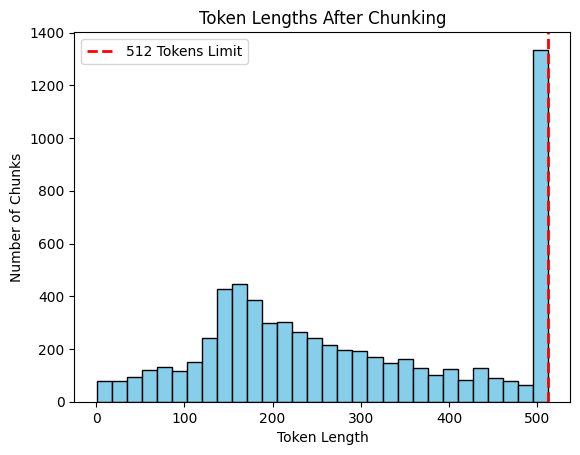

In [15]:
# From the cell above we have verified that the splitting was performed correctly

# Checking also with plot that indeed the tokens have length less than the maximum that roberta can take
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 Tokens Limit')
plt.title('Token Lengths After Chunking')
plt.xlabel('Token Length')
plt.ylabel('Number of Chunks')
plt.legend()
plt.show()

From the plot above we can see that everything is working as we wanted, there are no chunks with length larger than 512. We can see a lot of smaller chunks and a spike at 512 where the longer reviews were splitted. Now we can load the roberta model.

In [16]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

label2id = { "non-spoiler": 0,"spoiler": 1}
id2label = {0: "non-spoiler",1: "spoiler"}

model_name = "roberta-base"

config = RobertaConfig.from_pretrained(
    model_name,
    output_hidden_states = False,
    num_labels = 2,
    label2id = label2id,
    id2label = id2label )

In [17]:
# Initializing the model
model = RobertaForSequenceClassification.from_pretrained(model_name, config=config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Batch size and gradient accumulation -> these can be changed if needed
batch_size = 16
gradient_accumulation_steps = 2

In [19]:
# Logging steps
logging_steps = len(dataset_split["train"]) // (batch_size * gradient_accumulation_steps)

In [20]:
# Directory to save output
OUTPUT_DIR = "./"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [21]:
# Training arguments for roberta
# we want to match the chunked dataset so we will modify the previous arguements

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "roberta-model"),
    evaluation_strategy="epoch",                            # evaluate after every epoch
    save_strategy="epoch",                                  # and save
    logging_strategy="steps",
    logging_steps=logging_steps,                            # we calculated this above
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=3,                                   # number of epochs to train
    learning_rate=2e-5,                                   # learning rate
    weight_decay=0.02,                                    # weight decay
    load_best_model_at_end=True,                          # we want to get the best model by validation loss
    metric_for_best_model="eval_loss",                    # metric to use will be eval_loss
    greater_is_better=False,                              # we want to minimize the loss
    save_total_limit=2,
    logging_dir="./logs",
    report_to="wandb" )                                   # to use the Weights & Biases site

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Trainer setup
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])

<ipython-input-22-94c33ea09e95>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Finally, time to train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ctsekourona (ctsekourona-university-of-cyprus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# After training to calculate the metrics

# In order to predict on the test data
preds_output = trainer.predict(dataset_split["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

In [ ]:
# Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Evaluating
print(f"F1 Score : {f1_score(y_test, y_preds)}")
print(f"Accuracy : {accuracy_score(y_test, y_preds)}")
print(f"Precision: {precision_score(y_test, y_preds)}")
print(f"Recall   : {recall_score(y_test, y_preds)}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_preds)}")
print(classification_report(y_test, y_preds))

In [ ]:
model = trainer.model
model.save_pretrained(os.path.join(OUTPUT_DIR, 'roberta-model/pretrained'), save_config=True)

We evaluate and make predictions before aggregating.
The function of trainer.predict() is run on the test set which is also splitted into chunks. We will now aggregate by the review id to see how many of the full reviews are considered spoilers.

In [ ]:
# Getting the review_ids from the dataset
review_ids = [dataset_split["test"][i]["review_id"] for i in range(len(dataset_split["test"]))]

In [ ]:
# Creating a pandas dataframe to aggregate and store data
# The dataframe contains the review id , the true labels and the predicted ones
df_preds = pd.DataFrame({ "review_id": review_ids, "y_true": y_true, "y_pred": y_preds })

In [ ]:
# Now, we aggregate the predictions by the review
# What we want to do is to consider the whole review as a spoiler even if only one chunk is predicted as a spoiler

agg_preds = df_preds.groupby("review_id").agg({"y_true": "max", "y_pred": "max"}).reset_index()

In [ ]:
# Evaluating again, with the same metrics this time the whole reviews

print(f"F1 Score : {f1_score(agg_preds['y_true'], agg_preds['y_pred'])}")
print(f"Accuracy : {accuracy_score(agg_preds['y_true'], agg_preds['y_pred'])}")
print(f"Precision: {precision_score(agg_preds['y_true'], agg_preds['y_pred'])}")
print(f"Recall   : {recall_score(agg_preds['y_true'], agg_preds['y_pred'])}")
print(f"ROC AUC  : {roc_auc_score(agg_preds['y_true'], agg_preds['y_pred'])}")
print(classification_report(agg_preds['y_true'], agg_preds['y_pred']))